# 1) Project overview

Goal: Segment retail customers (US/UK) using KMeans so a business can personalize marketing.


# 1.Setup & Import

In [ ]:
# Install dependencies if needed
#!pip install pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Display settings
pd.set_option("display.max_columns", None)


# 2.Generate Synthetic Dataset

In [ ]:
np.random.seed(42)
n = 500

data = {
    "CustomerID": range(1, n+1),
    "Age": np.random.randint(18, 70, n),
    "Gender": np.random.choice(["Male", "Female"], n),
    "Region": np.random.choice(["US", "UK"], n, p=[0.6, 0.4]),
    "Annual_Income": np.random.randint(20000, 120000, n),
    "Annual_Spend": np.random.randint(5000, 80000, n),
    "Purchase_Frequency": np.random.randint(1, 50, n),
    "Avg_Basket_Value": np.random.randint(20, 500, n),
    "Loyalty_Score": np.random.randint(1, 11, n)  # 1–10 scale
}

df = pd.DataFrame(data)

# Save raw dataset
df.to_csv("customer_segmentation.csv", index=False)
print("✅ Dataset created: customer_segmentation.csv")
df.head()


✅ Dataset created: customer_segmentation.csv


,CustomerID,Age,Gender,Region,Annual_Income,Annual_Spend,Purchase_Frequency,Avg_Basket_Value,Loyalty_Score
0,1,56,Female,UK,110093,31155,46,266,5
1,2,69,Male,UK,55400,72278,49,362,7
2,3,46,Male,US,24494,23309,21,147,3
3,4,32,Female,UK,100688,5619,35,210,3
4,5,60,Male,US,109431,55108,32,86,10


# 3.Exploratory Data Analysis(EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CustomerID          500 non-null    int64 
 1   Age                 500 non-null    int64 
 2   Gender              500 non-null    object
 3   Region              500 non-null    object
 4   Annual_Income       500 non-null    int64 
 5   Annual_Spend        500 non-null    int64 
 6   Purchase_Frequency  500 non-null    int64 
 7   Avg_Basket_Value    500 non-null    int64 
 8   Loyalty_Score       500 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 35.3+ KB
None
                    count       mean           std      min       25%  \
CustomerID          500.0    250.500    144.481833      1.0    125.75   
Age                 500.0     44.220     15.036082     18.0     32.00   
Annual_Income       500.0  70738.016  28291.489543  20526.0  46652.50   
Annual_Spend        

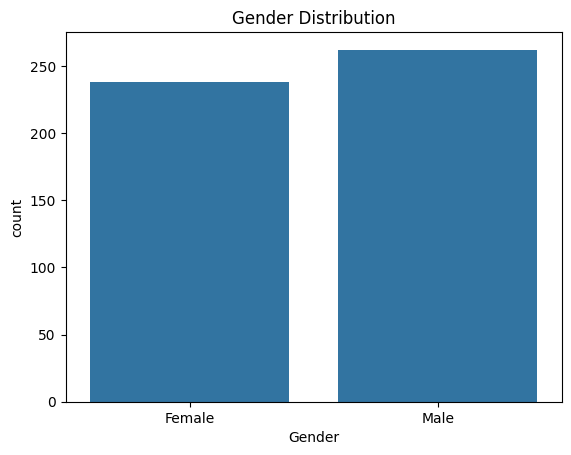

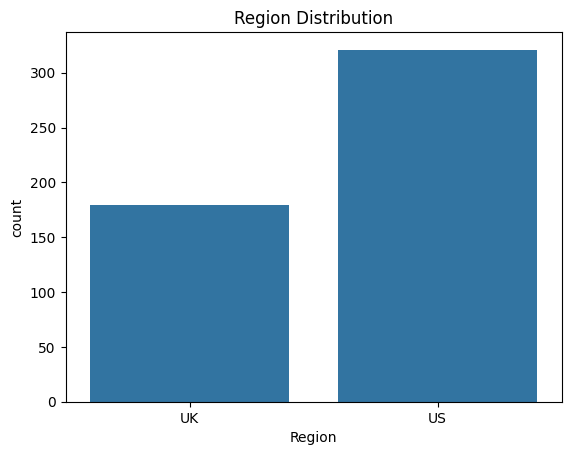

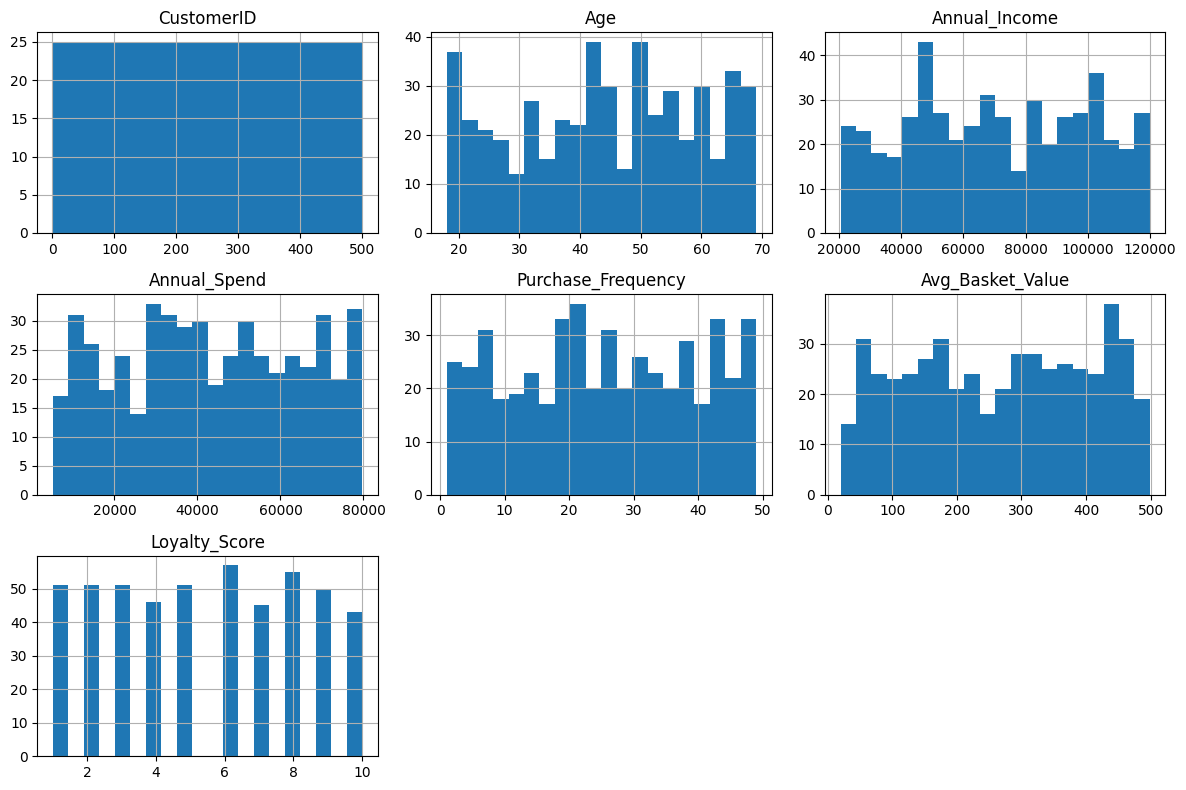

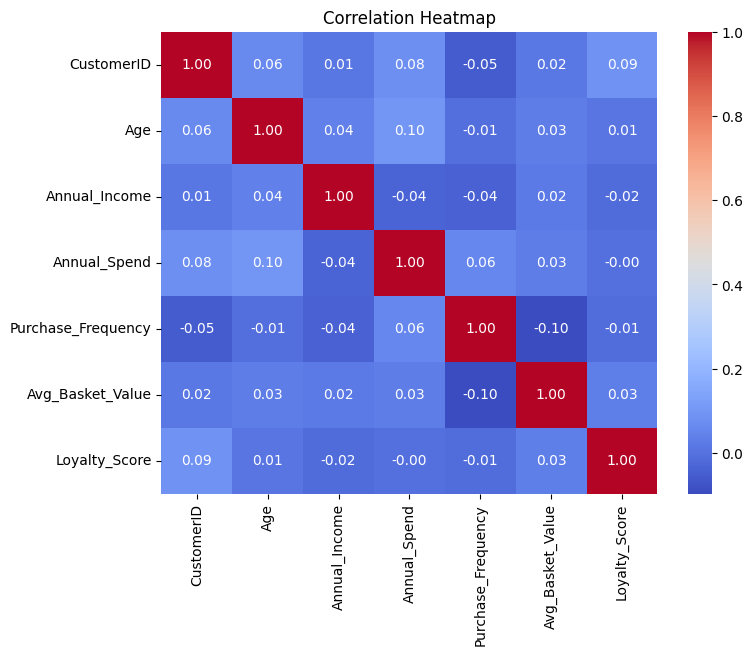

In [ ]:
print(df.info())
print(df.describe().T)

# Gender distribution
sns.countplot(data=df, x="Gender")
plt.title("Gender Distribution")
plt.show()

# Region distribution
sns.countplot(data=df, x="Region")
plt.title("Region Distribution")
plt.show()

# Histogram of numerical columns
df.hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 4.Feature Engineering


In [ ]:
# Age groups
#Created AgeGroups for buisness friendly bins:
bins = [17,25,35,45,55,70]
labels = ['18-25','26-35','36-45','46-55','56-70']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

# Derived feature: Spend per purchase
df['Spend_per_purchase'] = df['Annual_Spend'] / df['Purchase_Frequency']
df['Spend_per_purchase'] = df['Spend_per_purchase'].replace([np.inf, -np.inf], np.nan).fillna(df['Spend_per_purchase'].median())

df.head()


,CustomerID,Age,Gender,Region,Annual_Income,Annual_Spend,Purchase_Frequency,Avg_Basket_Value,Loyalty_Score,AgeGroup,Spend_per_purchase
0,1,56,Female,UK,110093,31155,46,266,5,56-70,677.282609
1,2,69,Male,UK,55400,72278,49,362,7,56-70,1475.061224
2,3,46,Male,US,24494,23309,21,147,3,46-55,1109.952381
3,4,32,Female,UK,100688,5619,35,210,3,26-35,160.542857
4,5,60,Male,US,109431,55108,32,86,10,56-70,1722.125000


# 5.Preparing Features for Clustering

In [ ]:
features = ["Age","Annual_Income","Annual_Spend","Purchase_Frequency","Avg_Basket_Value","Loyalty_Score","Spend_per_purchase"]
X = df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 6.Elbow & Silhouette Method(Choose k)


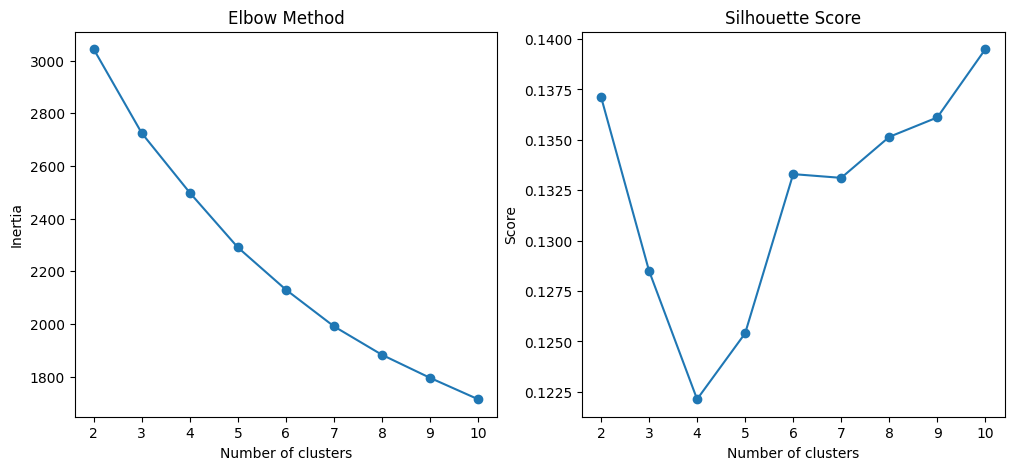

In [ ]:
inertia = []
sil = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertia, "o-")
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K, sil, "o-")
plt.title("Silhouette Score")
plt.xlabel("Number of clusters")
plt.ylabel("Score")

plt.show()


From the plots, pick k (3-5 is usually best). Let's use 4 here.


# 7.Train K Means

In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df["Cluster"] = kmeans.fit_predict(X_scaled)

print("✅ Clustering complete")
df.head()


✅ Clustering complete


,CustomerID,Age,Gender,Region,Annual_Income,Annual_Spend,Purchase_Frequency,Avg_Basket_Value,Loyalty_Score,AgeGroup,Spend_per_purchase,Cluster
0,1,56,Female,UK,110093,31155,46,266,5,56-70,677.282609,0
1,2,69,Male,UK,55400,72278,49,362,7,56-70,1475.061224,2
2,3,46,Male,US,24494,23309,21,147,3,46-55,1109.952381,0
3,4,32,Female,UK,100688,5619,35,210,3,26-35,160.542857,0
4,5,60,Male,US,109431,55108,32,86,10,56-70,1722.125000,2


# 8.Clusters Profiles


In [ ]:
# Average values per cluster
profile = df.groupby("Cluster")[features].mean().round(2)
profile["Count"] = df.groupby("Cluster")["CustomerID"].count()
profile


,Age,Annual_Income,Annual_Spend,Purchase_Frequency,Avg_Basket_Value,Loyalty_Score,Spend_per_purchase,Count
Cluster,,,,,,,,
0,43.33,66670.13,44583.36,33.42,220.31,2.86,1478.70,168
1,42.73,76663.59,39941.03,9.73,300.36,5.40,5972.04,153
2,45.79,68946.47,43887.78,32.40,282.99,8.06,1521.08,172
3,59.43,82871.86,60517.57,1.57,331.00,4.00,45175.36,7


# 9.Visualize Clusters(PCA)

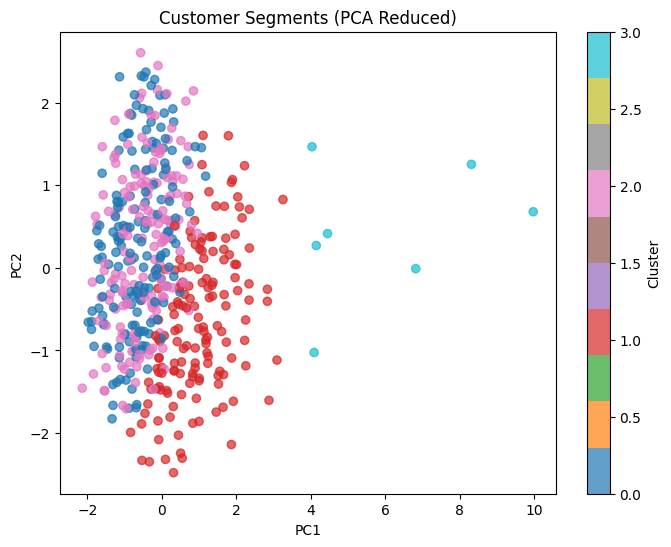

In [ ]:
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=df["Cluster"], cmap="tab10", alpha=0.7)
plt.title("Customer Segments (PCA Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


# 10.Export Segmented Data

In [ ]:
df.to_csv("customer_segments_with_clusters.csv", index=False)
print("✅ Segmented dataset saved: customer_segments_with_clusters.csv")


✅ Segmented dataset saved: customer_segments_with_clusters.csv
